In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark==3.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 15.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845492 sha256=a2a5f0dfd465f2c4c5c517e0d92d8ff3e4ee43377d68d0161535a26522e3d75a
  Stored in directory: /root/.cache/pip/wheels/0f/f0/3d/517368b8ce80486e84f89f214e0a022554e4ee64969f46279b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import round
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [5]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import pickle

In [6]:
# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('Home') \
                    .getOrCreate()

# Đọc dữ liệu

In [7]:
df_test = spark.read.csv('/content/drive/MyDrive/Final_BigData2/final/application_test.csv', sep=',', header=True, inferSchema=True, nullValue='NA')
df_test.show(5)

+----------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+------------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+------------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+--

In [8]:
df_train = spark.read.csv('/content/drive/MyDrive/Final_BigData2/final/application_train.csv', sep=',', header=True, inferSchema=True, nullValue='NA')
df_train.show(5)


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------

In [9]:
# Tính toán số lượng mỗi giá trị trong cột 'TARGET'
value_counts = df_train.groupBy("TARGET").count()

# Tính tỷ lệ của mỗi giá trị
value_ratios = value_counts.withColumn('ratio', col('count') / df_train.count())

# Chuyển đổi kết quả thành DataFrame
result_df = value_ratios.select('TARGET', 'ratio')

# Hiển thị kết quả
result_df.show()

+------+-------------------+
|TARGET|              ratio|
+------+-------------------+
|     1|0.08072881945686496|
|     0| 0.9192711805431351|
+------+-------------------+



In [10]:
value_counts.show()

+------+------+
|TARGET| count|
+------+------+
|     1| 24825|
|     0|282686|
+------+------+



<ipython-input-11-395a014b0d8c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(pandas_df, x="TARGET", palette='Accent');


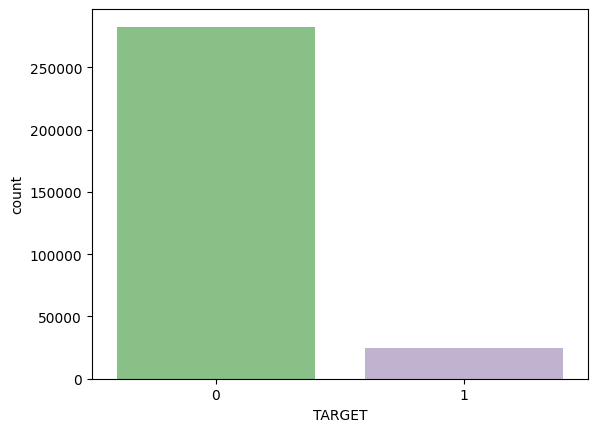

In [11]:
# Giả sử train là DataFrame của bạn
pandas_df = df_train.select("TARGET").toPandas()
sns.countplot(pandas_df, x="TARGET", palette='Accent');
plt.show();

In [12]:
# Số hàng (rows)
num_rows = df_train.count()

# Số cột (columns)
num_columns = len(df_train.columns)

# Kết quả tương tự với shape()
shape = (num_rows, num_columns)

print(f"Số hàng và cột trong DataFrame: {shape}")


Số hàng và cột trong DataFrame: (307511, 122)


In [13]:
from pyspark.sql.types import IntegerType, DoubleType, FloatType
# Lấy danh sách các cột có kiểu dữ liệu số
numeric_features = [field.name for field in df_train.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]

# Chọn các cột số từ DataFrame
df_numeric = df_train.select(*numeric_features)
# Tính toán các thống kê mô tả cho các cột số
df_numeric.describe().show()


+-------+------------------+-------------------+------------------+------------------+------------------+------------------+-----------------+--------------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+--------------------+---------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+--------------------+--------------

In [14]:
# Đếm số lượng mỗi giá trị trong cột 'CODE_GENDER'
df_train.groupBy("CODE_GENDER").count().show()


+-----------+------+
|CODE_GENDER| count|
+-----------+------+
|          F|202448|
|          M|105059|
|        XNA|     4|
+-----------+------+



In [15]:
from pyspark.sql.functions import when

# Thay thế giá trị 'XNA' thành 'F' trong cột 'CODE_GENDER' của train DataFrame
df_train = df_train.withColumn('CODE_GENDER', when(df_train['CODE_GENDER'] == 'XNA', 'F').otherwise(df_train['CODE_GENDER']))

# Thay thế giá trị 'XNA' thành 'F' trong cột 'CODE_GENDER' của test DataFrame
df_test = df_test.withColumn('CODE_GENDER', when(df_test['CODE_GENDER'] == 'XNA', 'F').otherwise(df_test['CODE_GENDER']))


In [16]:
# Đếm số lượng mỗi giá trị trong cột 'CODE_GENDER' sau khi thay thế
df_train.groupBy("CODE_GENDER").count().show()


+-----------+------+
|CODE_GENDER| count|
+-----------+------+
|          F|202452|
|          M|105059|
+-----------+------+



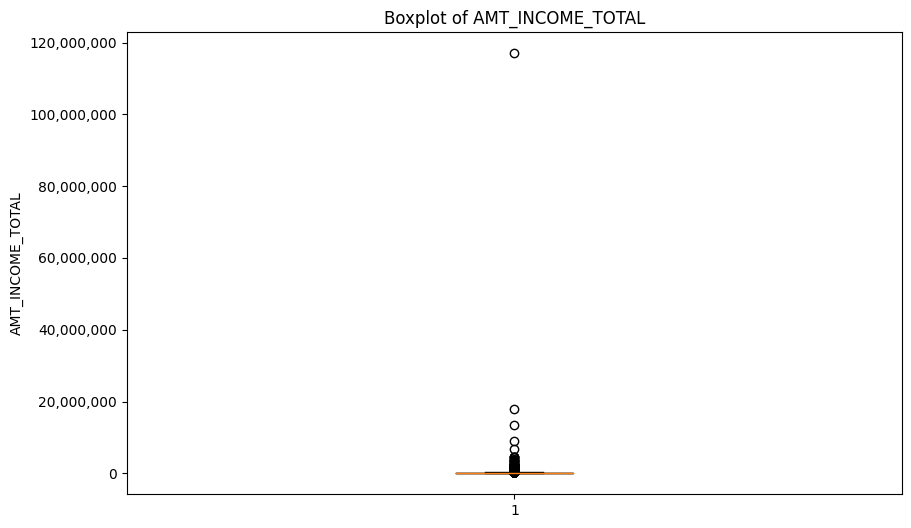

In [17]:
# Chuyển đổi DataFrame PySpark sang Pandas DataFrame
train_pd = df_train.select('AMT_INCOME_TOTAL').toPandas()

# Vẽ boxplot bằng matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot(train_pd['AMT_INCOME_TOTAL'])
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.ylabel('AMT_INCOME_TOTAL')
plt.title('Boxplot of AMT_INCOME_TOTAL')
plt.show()

In [18]:
from pyspark.sql.functions import format_number
# Tính toán các thống kê mô tả cho cột 'AMT_INCOME_TOTAL'
stats = df_train.describe(['AMT_INCOME_TOTAL'])

# Định dạng số liệu với hai chữ số thập phân
formatted_stats = stats.withColumn(
    'AMT_INCOME_TOTAL',
    format_number(stats['AMT_INCOME_TOTAL'].cast('double'), 2)
)

formatted_stats.show()

+-------+----------------+
|summary|AMT_INCOME_TOTAL|
+-------+----------------+
|  count|      307,511.00|
|   mean|      168,797.92|
| stddev|      237,123.15|
|    min|       25,650.00|
|    max|  117,000,000.00|
+-------+----------------+



In [19]:
df_test.count()

48744

In [20]:
df_train.count()

307511

In [21]:
# Sắp xếp và lấy 5 giá trị cao nhất
top_values_df = df_train.orderBy(col("AMT_INCOME_TOTAL").desc()).limit(5)

# Hiển thị kết quả
top_values_df.select("AMT_INCOME_TOTAL").show()

+----------------+
|AMT_INCOME_TOTAL|
+----------------+
|          1.17E8|
|      1.800009E7|
|          1.35E7|
|       9000000.0|
|       6750000.0|
+----------------+



In [22]:
from pyspark.sql.functions import col
from pyspark.sql import DataFrame

def filter_outliers_iqr(df: DataFrame, column_name: str) -> DataFrame:
    # Tính toán Q1 và Q3
    q1 = df.approxQuantile(column_name, [0.25], 0.05)[0]
    q3 = df.approxQuantile(column_name, [0.75], 0.05)[0]

    # Tính toán IQR
    iqr = q3 - q1

    # Xác định giới hạn cho outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Lọc outliers
    filtered_df = df.filter((col(column_name) >= lower_bound) & (col(column_name) <= upper_bound))

    return filtered_df

In [23]:
# Lọc outliers bằng IQR
df_train = filter_outliers_iqr(df_train, "AMT_INCOME_TOTAL")
df_test = filter_outliers_iqr(df_test, "AMT_INCOME_TOTAL")


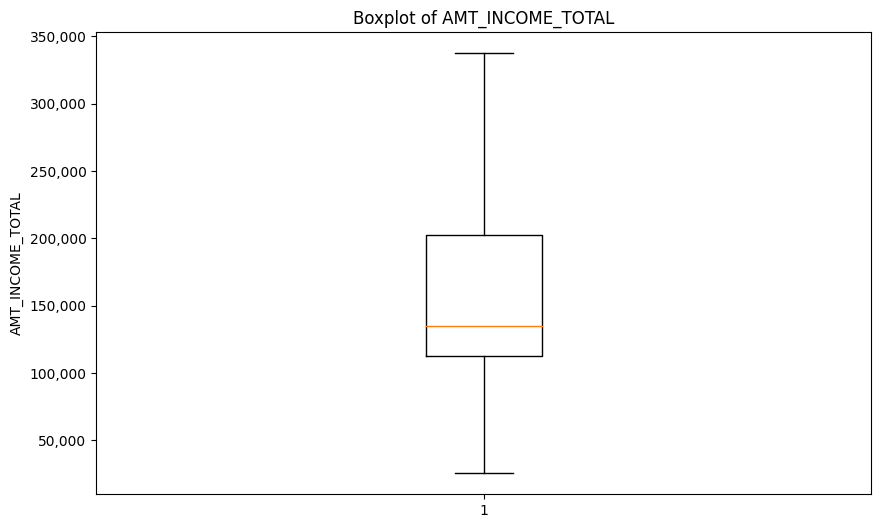

In [24]:
# Chuyển đổi DataFrame PySpark sang Pandas DataFrame
train_pd = df_train.select('AMT_INCOME_TOTAL').toPandas()

# Vẽ boxplot bằng matplotlib
plt.figure(figsize=(10, 6))
plt.boxplot(train_pd['AMT_INCOME_TOTAL'])
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.ylabel('AMT_INCOME_TOTAL')
plt.title('Boxplot of AMT_INCOME_TOTAL')
plt.show()

In [25]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, lit, when
from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType, StringType

def handle_missing_values(df: DataFrame) -> DataFrame:
    # Xử lý các cột số: điền giá trị median
    numeric_features = [field.name for field in df.schema.fields if isinstance(field.dataType, (DoubleType, FloatType, IntegerType, LongType))]

    for col_name in numeric_features:
        median_value = df.approxQuantile(col_name, [0.5], 0.05)[0]
        df = df.withColumn(col_name, when(col(col_name).isNull(), lit(median_value)).otherwise(col(col_name)))

    # Xử lý các cột phân loại: điền giá trị 'Unknown'
    categorical_features = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

    for col_name in categorical_features:
        df = df.withColumn(col_name, when(col(col_name).isNull(), lit('Unknown')).otherwise(col(col_name)))

    return df


In [26]:
# Áp dụng hàm handle_missing_values cho train và test
df_train = handle_missing_values(df_train)
df_test = handle_missing_values(df_test)


In [27]:
# Đếm số lượng các kiểu dữ liệu trong DataFrame
from collections import Counter

# Lấy danh sách kiểu dữ liệu của các cột trong DataFrame
data_types = [field.dataType for field in df_train.schema.fields]

# Sử dụng Counter để đếm số lượng mỗi kiểu dữ liệu
type_counts = Counter(data_types)

# Hiển thị kết quả
print(type_counts)


Counter({DoubleType(): 106, StringType(): 16})


In [28]:
from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType, StringType

# Xác định các kiểu dữ liệu số và phân loại
numeric_types = (DoubleType, FloatType, IntegerType, LongType)
categorical_types = (StringType,)

# Lấy danh sách các kiểu dữ liệu của các cột trong DataFrame
fields = df_train.schema.fields

# Lấy các cột số và phân loại
numeric_features = [field.name for field in fields if isinstance(field.dataType, numeric_types)]
categorical_features = [field.name for field in fields if isinstance(field.dataType, categorical_types)]

# In ra số lượng các loại tính năng
print('Count of numeric features:', len(numeric_features))
print('Count of categorical features:', len(categorical_features))
print('Total:', len(numeric_features) + len(categorical_features))


Count of numeric features: 106
Count of categorical features: 16
Total: 122


In [29]:
categorical_features


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [30]:
from pyspark.sql import functions as F
# Nhóm theo cột 'CODE_GENDER' và tính số lượng của mỗi giá trị trong cột 'TARGET'
result = (df_train.groupBy('CODE_GENDER', 'TARGET')
          .agg(F.count('*').alias('count'))
          .orderBy('CODE_GENDER', 'TARGET'))

# Hiển thị kết quả
result.show()

+-----------+------+------+
|CODE_GENDER|TARGET| count|
+-----------+------+------+
|          F|   0.0|181971|
|          F|   1.0| 13833|
|          M|   0.0| 87496|
|          M|   1.0| 10176|
+-----------+------+------+



In [31]:
# Chuyển đổi DataFrame PySpark sang Pandas DataFrame
pandas_df = result.toPandas()

# Pivot bảng
pivot_df = pandas_df.pivot(index='CODE_GENDER', columns='TARGET', values='count').fillna(0)


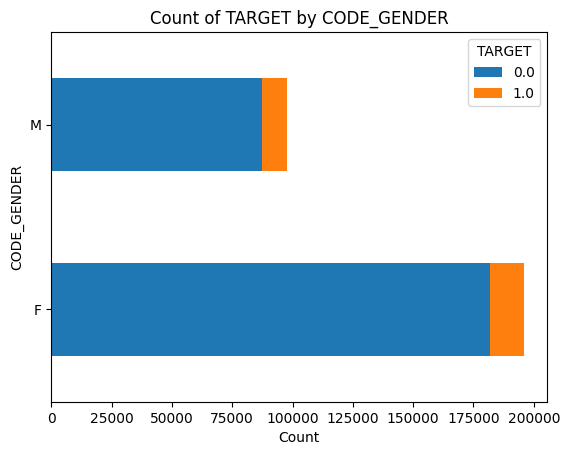

In [32]:
import matplotlib.pyplot as plt

# Vẽ đồ thị dạng barh (biểu đồ thanh ngang)
pivot_df.plot(kind='barh', stacked=True)

# Thêm tiêu đề và nhãn trục
plt.title('Count of TARGET by CODE_GENDER')
plt.xlabel('Count')
plt.ylabel('CODE_GENDER')

# Hiển thị đồ thị
plt.show()


In [33]:
from pyspark.sql import functions as F
# Nhóm theo cột 'CODE_GENDER' và tính số lượng của mỗi giá trị trong cột 'TARGET'
result = (df_train.groupBy('FLAG_OWN_CAR', 'TARGET')
          .agg(F.count('*').alias('count'))
          .orderBy('FLAG_OWN_CAR', 'TARGET'))

# Hiển thị kết quả
result.show()

+------------+------+------+
|FLAG_OWN_CAR|TARGET| count|
+------------+------+------+
|           N|   0.0|180119|
|           N|   1.0| 16856|
|           Y|   0.0| 89348|
|           Y|   1.0|  7153|
+------------+------+------+



In [34]:
# Chuyển đổi DataFrame PySpark sang Pandas DataFrame
pandas_df = result.toPandas()

# Pivot bảng
pivot_df = pandas_df.pivot(index='FLAG_OWN_CAR', columns='TARGET', values='count').fillna(0)

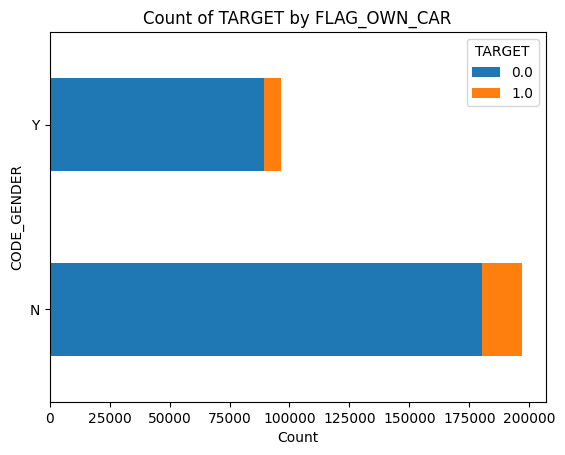

In [35]:

# Vẽ đồ thị dạng barh (biểu đồ thanh ngang)
pivot_df.plot(kind='barh', stacked=True)

# Thêm tiêu đề và nhãn trục
plt.title('Count of TARGET by FLAG_OWN_CAR')
plt.xlabel('Count')
plt.ylabel('CODE_GENDER')

# Hiển thị đồ thị
plt.show()


In [36]:
from pyspark.sql import functions as F
# Nhóm theo cột 'CODE_GENDER' và tính số lượng của mỗi giá trị trong cột 'TARGET'
result = (df_train.groupBy('FLAG_OWN_REALTY', 'TARGET')
          .agg(F.count('*').alias('count'))
          .orderBy('FLAG_OWN_REALTY', 'TARGET'))

# Hiển thị kết quả
result.show()

+---------------+------+------+
|FLAG_OWN_REALTY|TARGET| count|
+---------------+------+------+
|              N|   0.0| 82350|
|              N|   1.0|  7590|
|              Y|   0.0|187117|
|              Y|   1.0| 16419|
+---------------+------+------+



In [37]:
# Chuyển đổi DataFrame PySpark sang Pandas DataFrame
pandas_df = result.toPandas()

# Pivot bảng
pivot_df = pandas_df.pivot(index='FLAG_OWN_REALTY', columns='TARGET', values='count').fillna(0)

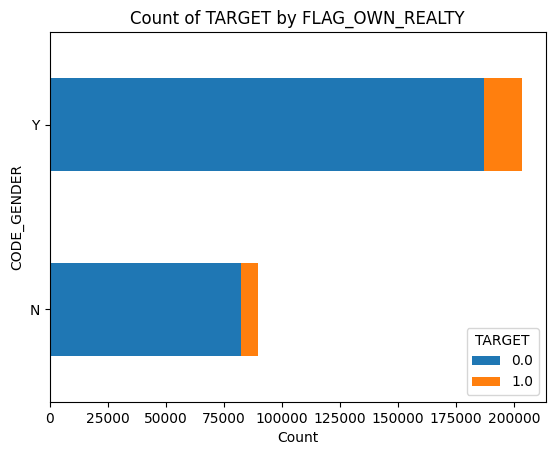

In [38]:

# Vẽ đồ thị dạng barh (biểu đồ thanh ngang)
pivot_df.plot(kind='barh', stacked=True)

# Thêm tiêu đề và nhãn trục
plt.title('Count of TARGET by FLAG_OWN_REALTY')
plt.xlabel('Count')
plt.ylabel('CODE_GENDER')

# Hiển thị đồ thị
plt.show()


In [39]:
numeric_features

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAR

In [40]:
# Chuyển đổi DataFrame PySpark sang Pandas DataFrame
pandas_df = df_train.toPandas()


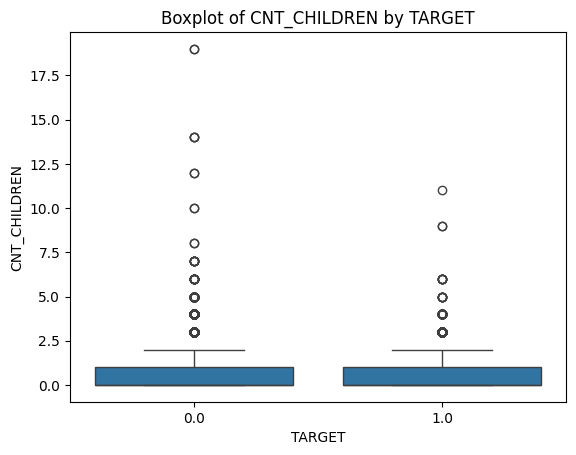

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ hộp
sns.boxplot(x='TARGET', y='CNT_CHILDREN', data=pandas_df)

# Hiển thị đồ thị
plt.title('Boxplot of CNT_CHILDREN by TARGET')
plt.xlabel('TARGET')
plt.ylabel('CNT_CHILDREN')
plt.show()


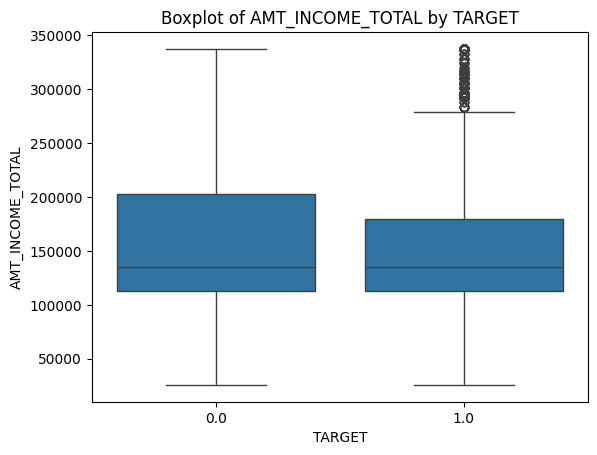

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ hộp
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=pandas_df)

# Hiển thị đồ thị
plt.title('Boxplot of AMT_INCOME_TOTAL by TARGET')
plt.xlabel('TARGET')
plt.ylabel('AMT_INCOME_TOTAL')
plt.show()


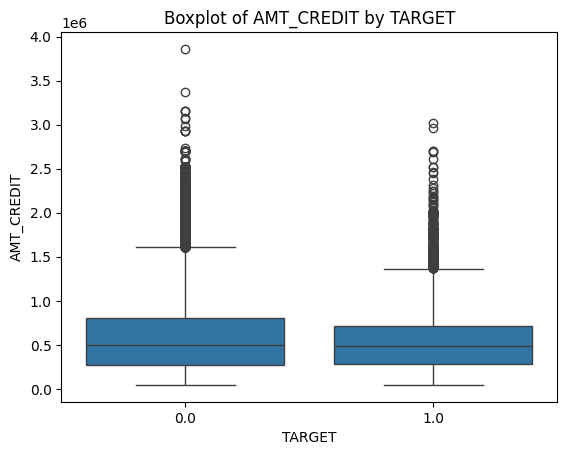

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ hộp
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=pandas_df)

# Hiển thị đồ thị
plt.title('Boxplot of AMT_CREDIT by TARGET')
plt.xlabel('TARGET')
plt.ylabel('AMT_CREDIT')
plt.show()


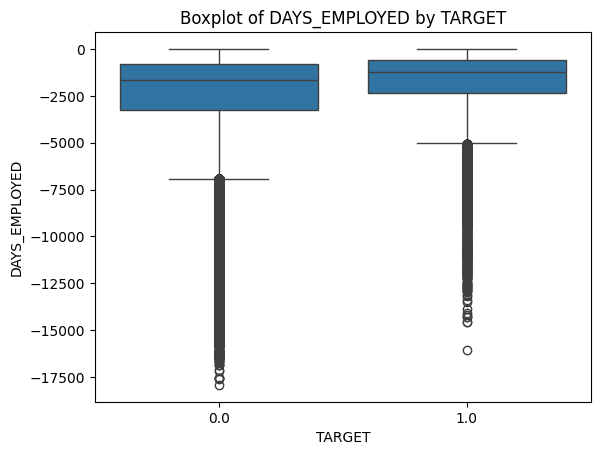

In [44]:
# Lọc dữ liệu
filtered_train = df_train.filter(df_train['DAYS_EMPLOYED'] < 0)

# Chuyển đổi DataFrame PySpark đã lọc sang Pandas DataFrame
pandas_filtered_df = filtered_train.toPandas()

# Vẽ biểu đồ hộp
sns.boxplot(x='TARGET', y='DAYS_EMPLOYED', data=pandas_filtered_df)

# Thêm tiêu đề và nhãn trục
plt.title('Boxplot of DAYS_EMPLOYED by TARGET')
plt.xlabel('TARGET')
plt.ylabel('DAYS_EMPLOYED')

# Hiển thị đồ thị
plt.show()

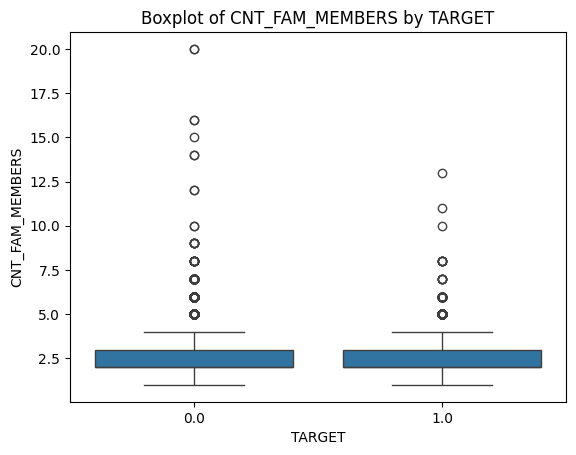

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vẽ biểu đồ hộp
sns.boxplot(x='TARGET', y='CNT_FAM_MEMBERS', data=pandas_df)

# Hiển thị đồ thị
plt.title('Boxplot of CNT_FAM_MEMBERS by TARGET')
plt.xlabel('TARGET')
plt.ylabel('CNT_FAM_MEMBERS')
plt.show()


# Onehot encoding biến phân loại

In [46]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import lit

In [47]:
# Thêm cột 'TARGET' vào df_test với giá trị null
df_test = df_test.withColumn('TARGET', lit(None).cast('double'))

# Kết hợp df_train và df_test
combined_df = df_train.unionByName(df_test)


In [48]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_features]
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_onehot"]) for col in categorical_features]


In [49]:
# Tạo pipeline
pipeline = Pipeline(stages=indexers + encoders)

# Áp dụng pipeline trên DataFrame đã gộp
model = pipeline.fit(combined_df)
one_hot_encoded = model.transform(combined_df)

In [50]:
import gc

In [51]:
 # Increase the maximum number of analyzer iterations
spark.conf.set("spark.sql.analyzer.maxIterations", 200)

# Giả sử bạn đã gộp train và test thành one_hot_encoded
train_count = df_train.count()  # Số lượng dòng trong tập train ban đầu

# Lấy lại tập train từ one_hot_encoded
train_one_hot = one_hot_encoded.limit(train_count)

# Lấy lại tập test từ one_hot_encoded bằng cách trừ đi tập train
test_one_hot = one_hot_encoded.subtract(train_one_hot)

# Kiểm tra số lượng dòng
print(f"Train shape: ({train_one_hot.count()}, {len(train_one_hot.columns)})")
print(f"Test shape: ({test_one_hot.count()}, {len(test_one_hot.columns)})")

# Giải phóng bộ nhớ
one_hot_encoded = None
gc.collect()

Train shape: (293476, 154)
Test shape: (46022, 154)


4189

In [52]:
# Trích xuất cột 'TARGET' từ train và chuyển đổi thành một danh sách (hoặc DataFrame)
y_train = train_one_hot.select('TARGET').rdd.flatMap(lambda x: x).collect()

# Loại bỏ cột 'TARGET' khỏi train
train = train_one_hot.drop('TARGET')

# Kiểm tra kích thước của train
print(f"Train shape: ({train.count()}, {len(train.columns)})")

# Tạo một bản sao logic của test
x_test = test_one_hot.select(*test_one_hot.columns)

# Kiểm tra kích thước của x_test
print(f"Test shape: ({x_test.count()}, {len(x_test.columns)})")

Train shape: (293476, 153)
Test shape: (46022, 154)


# Random forest

In [53]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [54]:
# Danh sách biến phân loại
categorical_cols = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_EDUCATION_TYPE',
    'NAME_INCOME_TYPE',
    'OCCUPATION_TYPE'
]

# Danh sách biến số
numeric_cols = [
    'AMT_CREDIT',
    'AMT_INCOME_TOTAL',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]


In [55]:
# Step 3: VectorAssembler để gộp các cột đầu vào thành một cột 'features'
assembler = VectorAssembler(
    inputCols=[column + "_onehot" for column in categorical_cols] + numeric_cols,
    outputCol='features'
)

In [56]:
# Chia lại tập train và test từ combined_df
train_count = df_train.count()  # Số lượng dòng trong tập train ban đầu
train_data = combined_df.limit(train_count)
test_data = combined_df.subtract(train_data)


# Chạy mô hình mà chưa undersampling

In [57]:
from pyspark.sql.functions import col, when
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer

# VectorAssembler để gộp các cột đầu vào thành một cột 'features'
assembler = VectorAssembler(
    inputCols=[column + "_onehot" for column in categorical_cols] + numeric_cols,
    outputCol='features'
)

# Chia lại tập train và test theo tỷ lệ 80% - 20%
train_data, test_data = combined_df.randomSplit([0.8, 0.2], seed=1)

# Đếm số lượng các mẫu của từng lớp trong biến target
count_class_0 = train_data.filter(train_data.TARGET == 0).count()
count_class_1 = train_data.filter(train_data.TARGET == 1).count()

# Xác định tỷ lệ trọng số (giả sử trọng số lớp thiểu số TARGET=1 cao hơn)
weight_for_class_1 = count_class_0 / count_class_1  # Tạo trọng số tỷ lệ nghịch với kích thước lớp

# Tạo cột trọng số dựa trên biến TARGET
train_data = train_data.withColumn("classWeightCol", when(col("TARGET") == 1, weight_for_class_1).otherwise(1))

# Thêm trọng số vào mô hình RandomForestClassifier
rf = RandomForestClassifier(
    labelCol="TARGET",
    featuresCol="features",
    numTrees=200,
    maxDepth=10,
    subsamplingRate=0.7,
    minInstancesPerNode=100,
    seed=1,
    weightCol="classWeightCol"  # Sử dụng trọng số cho lớp thiểu số
)

# Tạo Imputer chỉ cho các cột số để xử lý giá trị null
imputer = Imputer(
    inputCols=numeric_cols,
    outputCols=[column + "_imputed" for column in numeric_cols]
)

# Áp dụng Imputer và loại bỏ các giá trị null còn sót lại
train_data = imputer.fit(train_data).transform(train_data)
test_data = imputer.fit(test_data).transform(test_data)

# Loại bỏ các giá trị null trong toàn bộ dữ liệu (nếu còn)
train_data = train_data.na.drop()
test_data = test_data.na.drop()

# Cập nhật VectorAssembler để sử dụng các cột số đã được xử lý null cùng các cột one-hot encode
assembler = VectorAssembler(
    inputCols=[column + "_onehot" for column in categorical_cols] + [column + "_imputed" for column in numeric_cols],
    outputCol='features'
)

# Tạo pipeline
pipeline = Pipeline(stages=indexers + encoders + [imputer, assembler, rf])

# Train mô hình trên dữ liệu huấn luyện
model = pipeline.fit(train_data)

# Dự đoán trên tập huấn luyện và tập kiểm định
train_predictions = model.transform(train_data)
valid_predictions = model.transform(test_data)

# Khởi tạo evaluator để tính ROC AUC
evaluator = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")

# Tính ROC AUC trên tập huấn luyện
roc_auc_train = evaluator.evaluate(train_predictions)

# Loại bỏ các hàng có giá trị null trong cột 'TARGET' trước khi đánh giá
valid_predictions_filtered = valid_predictions.filter(valid_predictions["TARGET"].isNotNull())

# In kết quả đánh giá
print(f'ROC AUC trên tập huấn luyện: {roc_auc_train}')

# Evaluators cho các chỉ số khác nhau
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")


ROC AUC trên tập huấn luyện: 0.7580652127114965


Số lượng giá trị null trong cột 'TARGET' (train): 0
Số lượng giá trị null trong cột 'prediction' (train): 0
Số lượng giá trị null trong cột 'TARGET' (test): 0
Số lượng giá trị null trong cột 'prediction' (test): 0


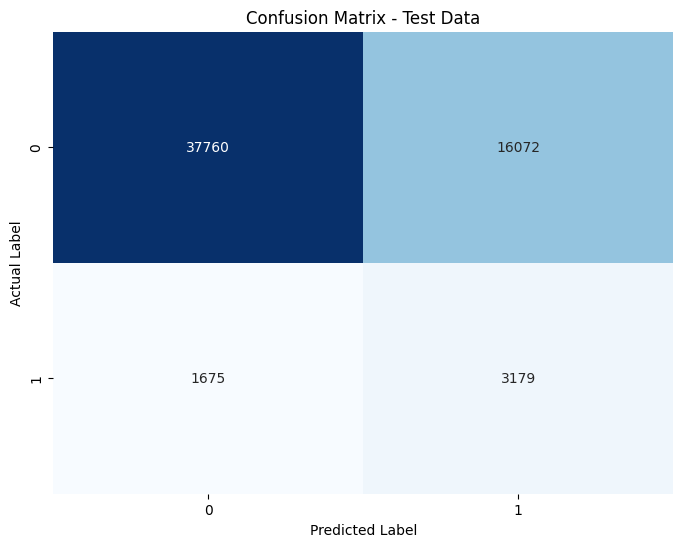

In [61]:
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập huấn luyện (train_data)
train_predictions = model.transform(train_data)

# Kiểm tra số lượng giá trị null trong cột TARGET và prediction (train_data)
null_target_count_train = train_predictions.filter(train_predictions["TARGET"].isNull()).count()
null_prediction_count_train = train_predictions.filter(train_predictions["prediction"].isNull()).count()

print(f"Số lượng giá trị null trong cột 'TARGET' (train): {null_target_count_train}")
print(f"Số lượng giá trị null trong cột 'prediction' (train): {null_prediction_count_train}")

# Lọc các giá trị null và chỉ giữ lại các bản ghi có giá trị hợp lệ cho tập huấn luyện
train_predictions_filtered = train_predictions.filter(
    train_predictions["TARGET"].isNotNull() & train_predictions["prediction"].isNotNull()
)

# Chuyển đổi cột 'TARGET' và 'prediction' sang Pandas DataFrame để tạo confusion matrix cho tập huấn luyện
preds_and_labels_train = train_predictions_filtered.select("TARGET", "prediction").toPandas()



# Dự đoán trên tập kiểm định (test_data)
valid_predictions = model.transform(test_data)

# Kiểm tra số lượng giá trị null trong cột TARGET và prediction (test_data)
null_target_count_valid = valid_predictions.filter(valid_predictions["TARGET"].isNull()).count()
null_prediction_count_valid = valid_predictions.filter(valid_predictions["prediction"].isNull()).count()

print(f"Số lượng giá trị null trong cột 'TARGET' (test): {null_target_count_valid}")
print(f"Số lượng giá trị null trong cột 'prediction' (test): {null_prediction_count_valid}")

# Lọc các giá trị null và chỉ giữ lại các bản ghi có giá trị hợp lệ cho tập kiểm định
valid_predictions_filtered = valid_predictions.filter(
    valid_predictions["TARGET"].isNotNull() & valid_predictions["prediction"].isNotNull()
)

# Chuyển đổi cột 'TARGET' và 'prediction' sang Pandas DataFrame để tạo confusion matrix cho tập kiểm định
preds_and_labels_valid = valid_predictions_filtered.select("TARGET", "prediction").toPandas()

# Tạo ma trận nhầm lẫn cho tập kiểm định
if preds_and_labels_valid.empty:
    print("Không có dữ liệu để tạo ma trận nhầm lẫn cho tập kiểm định.")
else:
    conf_matrix_valid = confusion_matrix(preds_and_labels_valid["TARGET"], preds_and_labels_valid["prediction"])

    # Vẽ ma trận nhầm lẫn cho tập kiểm định
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_valid, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix - Test Data")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()

## Undersampling


In [62]:
# Chia lại tập train và test từ combined_df
train_count = df_train.count()  # Số lượng dòng trong tập train ban đầu
train_data = combined_df.limit(train_count)
test_data = combined_df.subtract(train_data)

In [63]:
# Đếm số lượng các mẫu của từng lớp trong biến target
count_class_0 = train_data.filter(train_data.TARGET == 0).count()
count_class_1 = train_data.filter(train_data.TARGET == 1).count()

# Xác định tỷ lệ mong muốn (ví dụ: 70% cho lớp 0 và 30% cho lớp 1)
desired_ratio = 0.7

# Tính toán số lượng mẫu cần lấy từ lớp 0 dựa trên tỷ lệ mong muốn
desired_count_class_0 = int(count_class_1 * (desired_ratio / (1 - desired_ratio)))

# Lấy mẫu từ lớp 0 sao cho đạt được số lượng mẫu mong muốn
df_class_0_undersampled = df_train.filter(train_data.TARGET == 0).sample(False, float(desired_count_class_0) / count_class_0)

# Giữ nguyên tất cả các mẫu của lớp 1
df_class_1 = train_data.filter(df_train.TARGET == 1)

# Kết hợp lại dữ liệu của cả hai lớp
train_data_rf = df_class_0_undersampled.union(df_class_1)

In [64]:
train_data, test_data = train_data_rf.randomSplit([0.8, 0.2], seed=1)

<ipython-input-65-0f7b4ee1ba94>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(pandas_df, x="TARGET", palette='Accent');


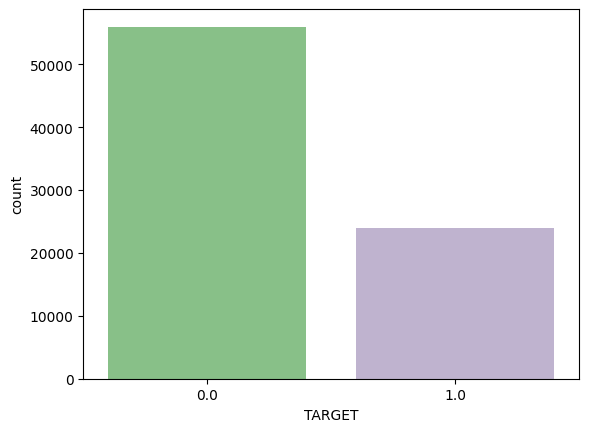

In [65]:
# Giả sử train là DataFrame của bạn
pandas_df = train_data_rf.select("TARGET").toPandas()
sns.countplot(pandas_df, x="TARGET", palette='Accent');
plt.show();

In [66]:
pandas_df = train_data_rf.select("TARGET").toPandas()
pandas_df.TARGET.value_counts()

,count
TARGET,
0.0,55977
1.0,24009


In [67]:
# Tạo cột trọng số
train_data = train_data.withColumn("classWeightCol", when(col("TARGET") == 1, 1.5).otherwise(1))

# Thêm trọng số vào mô hình
rf = RandomForestClassifier(
    labelCol="TARGET",
    featuresCol="features",
    numTrees=200,
    maxDepth=10,
    subsamplingRate=0.7,
    minInstancesPerNode=100,
    seed=1,
    weightCol="classWeightCol"  # Sử dụng trọng số cho lớp thiểu số
)


In [68]:
# Tạo pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])


In [71]:
from pyspark.sql.functions import col,isnan, when, count # Import the count function

train_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_data.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+----

In [72]:
# Tạo Imputer chỉ cho các cột số để xử lý giá trị null
imputer = Imputer(
    inputCols=numeric_cols,
    outputCols=[column + "_imputed" for column in numeric_cols]
)

# Áp dụng Imputer và loại bỏ các giá trị null còn sót lại
train_data = imputer.fit(train_data).transform(train_data)
test_data = imputer.fit(test_data).transform(test_data)

# Loại bỏ các giá trị null trong toàn bộ dữ liệu (nếu còn)
train_data = train_data.na.drop()
test_data = test_data.na.drop()

# Cập nhật VectorAssembler để sử dụng các cột số đã được xử lý null cùng các cột one-hot encode
assembler = VectorAssembler(
    inputCols=[column + "_onehot" for column in categorical_cols] + [column + "_imputed" for column in numeric_cols],
    outputCol='features'
)


In [73]:
# Train mô hình
model = pipeline.fit(train_data)

In [74]:
# Dự đoán trên tập huấn luyện và tập kiểm định
train_predictions = model.transform(train_data)
valid_predictions = model.transform(test_data)

In [75]:
# Khởi tạo evaluator để tính ROC AUC
evaluator = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")

In [76]:
# Inspect schemas and sample values
print("Train predictions schema:")
train_predictions.select("rawPrediction", "probability").printSchema()
print("Sample values:")
train_predictions.select("rawPrediction", "probability").show(5)

print("Valid predictions schema:")
valid_predictions.select("rawPrediction", "probability").printSchema()
print("Sample values:")
valid_predictions.select("rawPrediction", "probability").show(5)

Train predictions schema:
root
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)

Sample values:
+--------------------+--------------------+
|       rawPrediction|         probability|
+--------------------+--------------------+
|[146.739723217940...|[0.73369861608970...|
|[142.079344548235...|[0.71039672274117...|
|[137.993827000603...|[0.68996913500301...|
|[114.134621415122...|[0.57067310707561...|
|[144.788185389755...|[0.72394092694877...|
+--------------------+--------------------+
only showing top 5 rows

Valid predictions schema:
root
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)

Sample values:
+--------------------+--------------------+
|       rawPrediction|         probability|
+--------------------+--------------------+
|[125.873064192701...|[0.62936532096350...|
|[133.524857696015...|[0.66762428848007...|
|[112.575870140130...|[0.56287935070065...|
|[123.505834162579...|[0.61752917081289...|
|

In [77]:
# Tính ROC AUC trên tập huấn luyện
roc_auc_train = evaluator.evaluate(train_predictions)

# Loại bỏ các hàng có giá trị null trong cột 'TARGET' trước khi đánh giá
valid_predictions_filtered = valid_predictions.filter(valid_predictions["TARGET"].isNotNull())

# In kết quả đánh giá
print(f'ROC AUC: {roc_auc_train}')


ROC AUC: 0.7473256925321969


In [78]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Tạo evaluator để tính Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")

# Tính Accuracy trên tập huấn luyện
train_accuracy = accuracy_evaluator.evaluate(train_predictions)

# In kết quả đánh giá
print(f'Accuracy: {train_accuracy}')

# Giải phóng bộ nhớ
gc.collect()


Accuracy: 0.7378270150672338


4067

In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluator để tính ROC AUC
roc_evaluator = BinaryClassificationEvaluator(labelCol="TARGET", rawPredictionCol="probability", metricName="areaUnderROC")

# Tính ROC AUC trên tập huấn luyện
roc_auc_train = roc_evaluator.evaluate(train_predictions)

# In kết quả ROC AUC
print(f'ROC AUC: {roc_auc_train}')


ROC AUC: 0.7473275688008392


In [80]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluators cho các chỉ số khác nhau
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="weightedRecall")

# Tính Accuracy, F1-score, Precision, và Recall trên tập huấn luyện
train_accuracy = accuracy_evaluator.evaluate(train_predictions)
train_f1 = f1_evaluator.evaluate(train_predictions)
train_precision = precision_evaluator.evaluate(train_predictions)
train_recall = recall_evaluator.evaluate(train_predictions)

# In kết quả đánh giá
print(f'Accuracy: {train_accuracy}')
print(f'F1-Score: {train_f1}')
print(f'Precision: {train_precision}')
print(f'Recall: {train_recall}')

Accuracy: 0.7378270150672338
F1-Score: 0.7230405588848727
Precision: 0.7213898835287651
Recall: 0.7378270150672338


Số lượng giá trị null trong cột 'TARGET' (train): 0
Số lượng giá trị null trong cột 'prediction' (train): 0


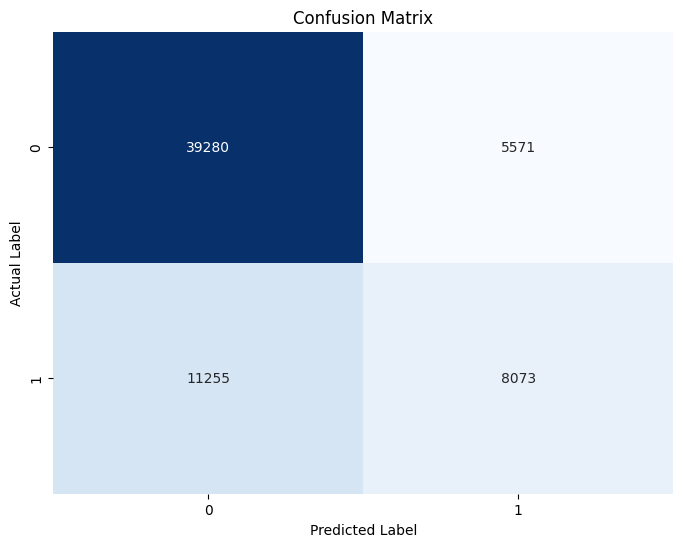

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Dự đoán trên tập huấn luyện (train_data)
train_predictions = model.transform(train_data)

# Kiểm tra số lượng giá trị null trong cột TARGET và prediction
null_target_count_train = train_predictions.filter(train_predictions["TARGET"].isNull()).count()
null_prediction_count_train = train_predictions.filter(train_predictions["prediction"].isNull()).count()

print(f"Số lượng giá trị null trong cột 'TARGET' (train): {null_target_count_train}")
print(f"Số lượng giá trị null trong cột 'prediction' (train): {null_prediction_count_train}")

# Lọc các giá trị null và chỉ giữ lại các bản ghi có giá trị hợp lệ
train_predictions_filtered = train_predictions.filter(
    train_predictions["TARGET"].isNotNull() & train_predictions["prediction"].isNotNull()
)

# Chuyển đổi cột 'TARGET' và 'prediction' sang Pandas DataFrame để tạo confusion matrix
preds_and_labels_train = train_predictions_filtered.select("TARGET", "prediction").toPandas()

# Tạo ma trận nhầm lẫn
if preds_and_labels_train.empty:
    print("Không có dữ liệu để tạo ma trận nhầm lẫn.")
else:
    conf_matrix_train = confusion_matrix(preds_and_labels_train["TARGET"], preds_and_labels_train["prediction"])

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [82]:
train_one_hot.groupBy('TARGET').count().show()


+------+------+
|TARGET| count|
+------+------+
|   1.0| 24009|
|   0.0|269467|
+------+------+



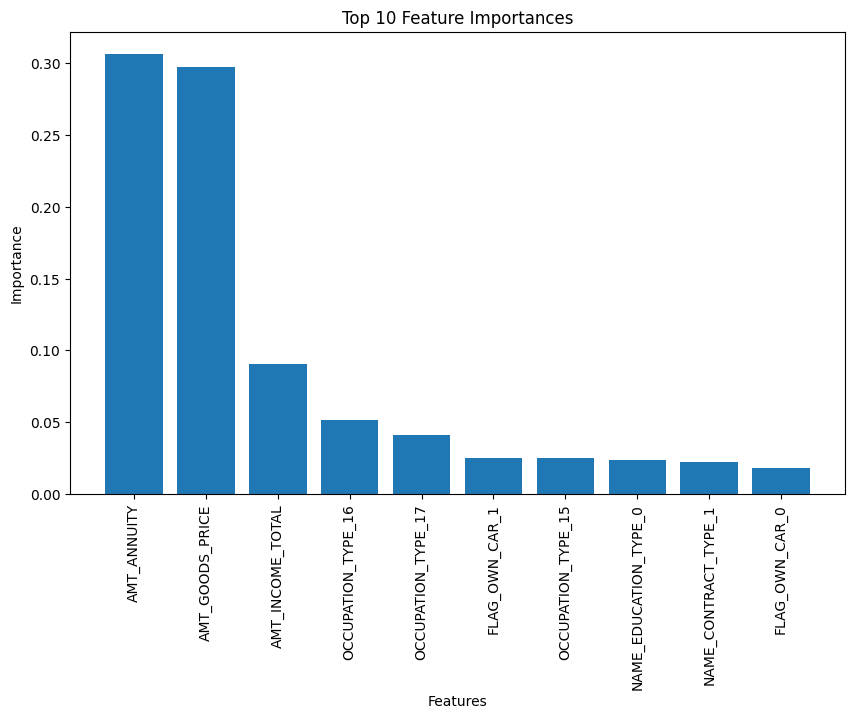

In [83]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# # Bước 1: Mã hóa các biến phân loại
# indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
# encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_onehot") for col in categorical_cols]

# # Bước 2: Kết hợp tất cả các đặc trưng thành một cột duy nhất
# assembler = VectorAssembler(
#     inputCols=[col + "_onehot" for col in categorical_cols] + numeric_cols,
#     outputCol="features"
# )

# # Bước 4: Tạo Pipeline và huấn luyện mô hình
# pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
# pipeline_model = pipeline.fit(train_data)

# Bước 5: Trích xuất mô hình RandomForest từ PipelineModel
rf_model = model.stages[-1]

# Bước 6: Lấy tên các đặc trưng sau khi mã hóa
feature_names = []
for col in categorical_cols:
    # Giả sử mỗi biến phân loại có số lượng mã hóa khác nhau
    encoded_size = train_data.select(col).distinct().count()  # Số lượng giá trị phân loại khác nhau
    feature_names.extend([f"{col}_{i}" for i in range(encoded_size)])

# Thêm các biến số học
feature_names.extend(numeric_cols)

# Bước 7: Trích xuất tầm quan trọng của các đặc trưng
# Access featureImportances from the RandomForestClassificationModel (rf_model)
importances = rf_model.featureImportances.toArray()

# Sắp xếp tầm quan trọng và các đặc trưng
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

# Lấy top 10 đặc trưng quan trọng nhất
top_features = sorted_features[:10]
top_importances = sorted_importances[:10]

# Bước 8: Vẽ biểu đồ tầm quan trọng của các đặc trưng
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_features)), top_importances, tick_label=top_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()

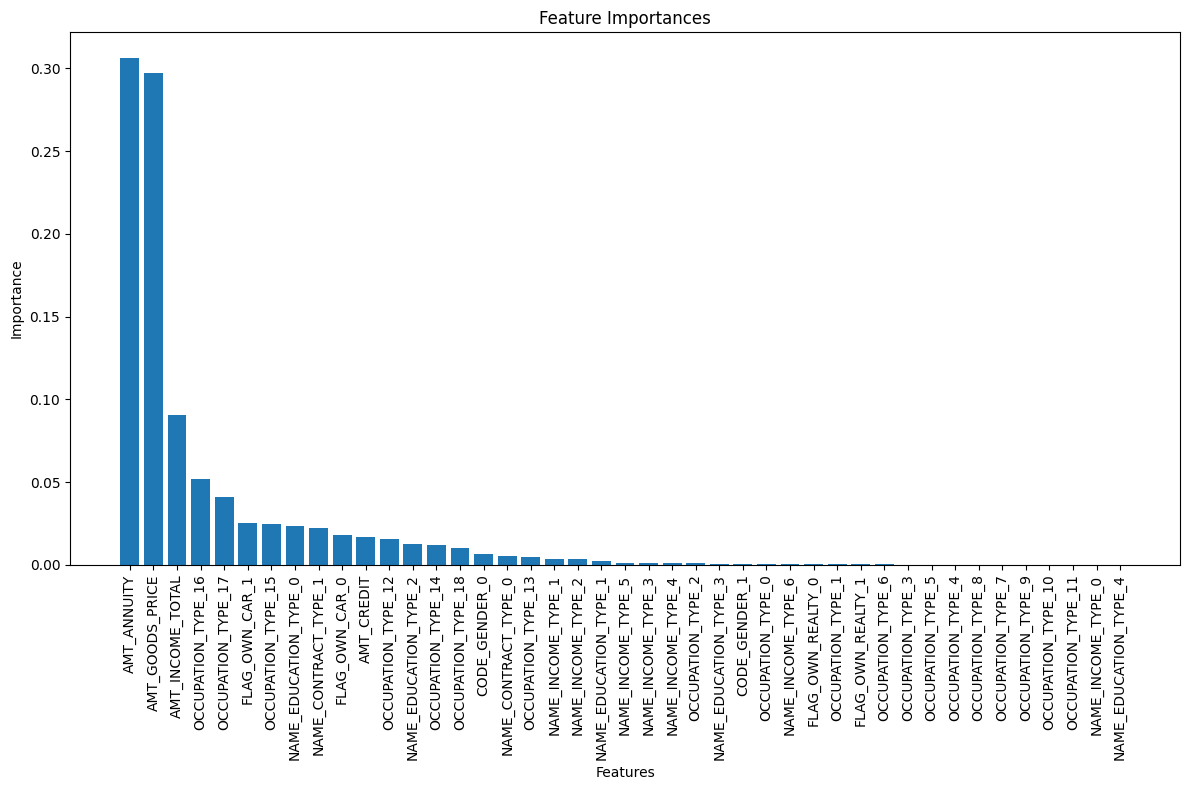

In [84]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# # Bước 1: Mã hóa các biến phân loại
# indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
# encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_onehot") for col in categorical_cols]

# # Bước 2: Kết hợp tất cả các đặc trưng thành một cột duy nhất
# assembler = VectorAssembler(
#     inputCols=[col + "_onehot" for col in categorical_cols] + numeric_cols,
#     outputCol="features"
# )

# # Bước 4: Tạo Pipeline và huấn luyện mô hình
# pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
# pipeline_model = pipeline.fit(train_data)

# Bước 5: Trích xuất mô hình RandomForest từ PipelineModel
rf_model = model.stages[-1]

# Bước 6: Lấy tên các đặc trưng sau khi mã hóa
feature_names = []
for col in categorical_cols:
    # Giả sử mỗi biến phân loại có số lượng mã hóa khác nhau
    encoded_size = train_data.select(col).distinct().count()  # Số lượng giá trị phân loại khác nhau
    feature_names.extend([f"{col}_{i}" for i in range(encoded_size)])

# Thêm các biến số học
feature_names.extend(numeric_cols)

# Bước 7: Trích xuất tầm quan trọng của các đặc trưng
importances = rf_model.featureImportances.toArray()

# Sắp xếp tầm quan trọng và các đặc trưng
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = np.array(feature_names)[sorted_indices]

# Bước 8: Vẽ biểu đồ tầm quan trọng của tất cả các đặc trưng
plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_features)), sorted_importances, tick_label=sorted_features)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()
